# Classification task in ENEM 2016 exam
What is ENEM?
>   "O Exame Nacional do Ensino Médio (ENEM, or National High School Exam) is a non-mandatory, standardized Brazilian national exam, which evaluates high school students in Brazil. The ENEM is used as an admission exam for enrollment in many Universities in Brazil, as well as for a high school degree certification. The examination is likewise used by individuals wanting to earn points in 'the University for All Programme', or ProUni, a federal scholarship programme (Programa Universidade para Todos). The ENEM exam comprises of 180 multiple-choice questions and tests students in **five main areas**, namely natural sciences, math, human sciences, Portuguese and either English or Spanish as a foreign language. Students are also required to write an essay."  Font: [Brazil Education](https://www.brazileducation.info/tests/higher-education-tests/enem-in-brazil.html)

**Problem**: Classify which stundents are taking the ENEM exam for "test" (Treineiro).

**Requisites**: Achieve accuracy higher than 90%


In [1]:
import sklearn
import numpy as np 
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE

from sklearn import metrics
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold


from IPython.display import display_html

In [2]:
# Reading dataset
test_raw = pd.read_csv(r'dataset/test.csv')
train_raw = pd.read_csv(r'dataset/train.csv')

In [3]:
test_raw.head(5)

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,ba0cc30ba34e7a46764c09dfc38ed83d15828897,43,RS,19,F,1,1,1,3,1,...,NaN,NaN,E,E,H,B,B,C,D,A
1,177f281c68fa032aedbd842a745da68490926cd2,15,PA,24,M,3,2,1,4,1,...,NaN,NaN,B,C,B,A,A,C,D,A
2,6cf0d8b97597d7625cdedc7bdb6c0f052286c334,29,BA,16,F,2,1,3,0,1,...,NaN,NaN,E,F,G,B,B,A,NaN,D
3,5c356d810fa57671402502cd0933e5601a2ebf1e,41,PR,17,F,1,1,2,0,2,...,40.0,480.0,E,E,E,C,B,B,C,A
4,df47c07bd881c2db3f38c6048bf77c132ad0ceb3,53,DF,19,F,1,1,1,1,1,...,80.0,720.0,E,E,E,B,B,B,D,A


In [4]:
train_raw.head(5)

,Unnamed: 0,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,...,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
0,1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,...,5.0,A,A,A,A,A,A,A,B,D
1,2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,...,NaN,A,A,C,A,B,A,A,C,A
2,3,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,2016,2304400,Fortaleza,23,CE,21,F,0.0,...,NaN,A,A,A,A,C,A,A,B,A
3,4,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,2016,3304557,Rio de Janeiro,33,RJ,25,F,0.0,...,5.0,C,A,A,A,A,D,A,A,A
4,5,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,2016,1302603,Manaus,13,AM,28,M,0.0,...,NaN,A,A,A,A,A,A,A,A,A


Since train and test dataset have different features available, I will use the features shared in both dataframes. However, I need to add my target variable, i.e. 'NU_NOTA_MT' in df_train.

In [5]:
# Create a train dataframe with same features in test
features = test_raw.columns.tolist() 
features.extend(['NU_NOTA_MT', 'IN_TREINEIRO'])
df_train = train_raw[features]
df_train.head(4)

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047,NU_NOTA_MT,IN_TREINEIRO
0,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,43,RS,24,M,1,1,1,4,1,...,D,D,C,A,A,C,H,A,399.4,0
1,2c3acac4b33ec2b195d77e7c04a2d75727fad723,23,CE,17,F,3,1,2,0,2,...,A,A,B,A,A,A,NaN,A,459.8,0
2,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,23,CE,21,F,3,1,3,0,1,...,D,D,C,A,A,A,NaN,A,NaN,0
3,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,33,RJ,25,F,0,1,1,9,1,...,H,E,E,C,B,C,F,D,NaN,0


In [6]:
# Overiding jupyter style to plot dataframes side by side
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

## Understanding the features
To better understand our features, we need to analyse it and check if we have any redundant variables that could be easily dropped.
Let's start this with data description:

*   **ID**: 'NU_INSCRICAO'

*   **Student**:    'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE', 'IN_IDOSO', 'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'IN_SABATISTA'

*   **Student health**:  'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_GESTANTE'

*   **High school**:  'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU','TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO', 'TP_DEPENDENCIA_ADM_ESC'

*  **Student exam info**: 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT',  'TP_LINGUA'

*  **Grades**: 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO',  'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC'

*  **Family background**: 'Q001', 'Q002', 'Q006', 'Q024', 'Q025', 'Q026', 'Q027', 'Q047'

By splitting features in these categories we can easily check redundant information, for example:
>   CO_UF_RESIDENCIA (same info as SG_UF_RESIDENCIA)

>   IN_IDOSO (already specified in NU_IDADE)

In [7]:
# Drop columns
df_train = df_train.drop(['CO_UF_RESIDENCIA', 'IN_IDOSO', 'NU_INSCRICAO'], axis=1)
df_test = test_raw.drop(['CO_UF_RESIDENCIA', 'IN_IDOSO', 'NU_INSCRICAO'], axis=1)

print('Number of features: ', len(df_train.columns))

Number of features:  42


# Data Investigation
- Scatter plot between variables and target (math grade)
- Histogram 
- Boxplot (check outliers and data distribution - violin plot)

In [8]:
# Function to get numerical and categorical features
def cols_numeric_categ(df):
    numeric_cols = df.select_dtypes(include=['float', 'int']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    return numeric_cols, categorical_cols

In [9]:
# Extract numerical variables
numeric, categorical = cols_numeric_categ(df_train)
print(f"Numerical features {len(numeric)}, Categorical features {len(categorical)}")

Numerical features 32, Categorical features 10


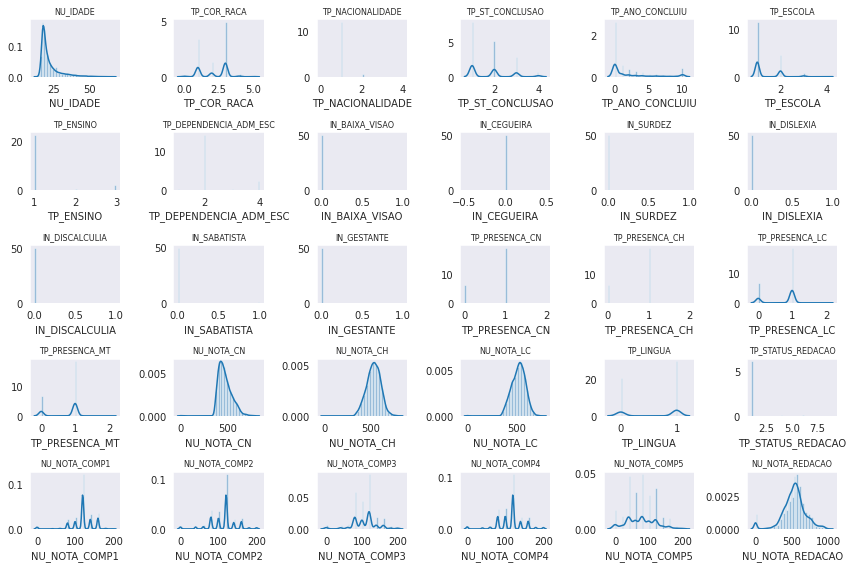

In [10]:
# Histogram for numerical variables x math grades
sns.set_style("dark")

fig, axes = plt.subplots(figsize=(12,8), nrows=5, ncols=6)
axes = axes.flatten()

for feature, ax in zip(numeric, axes):
    sns.distplot(
        df_train[feature],
        bins=50,
        ax=ax)
    ax.set_title(feature, fontsize=8)
    
fig.tight_layout()

[87.01, 12.99]

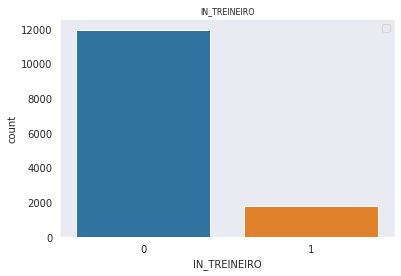

In [11]:
# Let's take a more detailed look in IN_TREINEIRO
sns.countplot(
    x='IN_TREINEIRO',
    data=df_train)
plt.title('IN_TREINEIRO', fontsize=8)
plt.legend('')

count_treineiro = df_train['IN_TREINEIRO'].value_counts()
count_treineiro = [round(val * 100 / np.sum(count_treineiro), 2) for val in count_treineiro]
count_treineiro

Inside numerical features list there are categorical variables (for example, 'N_SABATISTA'). I will remove them from numerical list and put into categorical list

In [12]:
misplaced_features = [
    'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO',
    'TP_ANO_CONCLUIU',  'TP_ESCOLA',  'IN_TREINEIRO',
    'IN_BAIXA_VISAO', 'IN_CEGUEIRA',  'IN_SURDEZ',
    'IN_DISLEXIA', 'IN_DISCALCULIA',  'IN_SABATISTA',
    'IN_GESTANTE', 'TP_PRESENCA_CN','TP_PRESENCA_CH', 
    'TP_PRESENCA_LC',  'TP_LINGUA','TP_ENSINO', 
    'TP_DEPENDENCIA_ADM_ESC', 'TP_STATUS_REDACAO'
    ]

# Adding misplaced features to categorical list
[categorical.append(item) for item in misplaced_features]

# Removing misplaced from numeric list
numeric = [item for item in numeric if item not in misplaced_features]
numeric

['NU_IDADE',
 'TP_PRESENCA_MT',
 'NU_NOTA_CN',
 'NU_NOTA_CH',
 'NU_NOTA_LC',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_REDACAO',
 'NU_NOTA_MT']

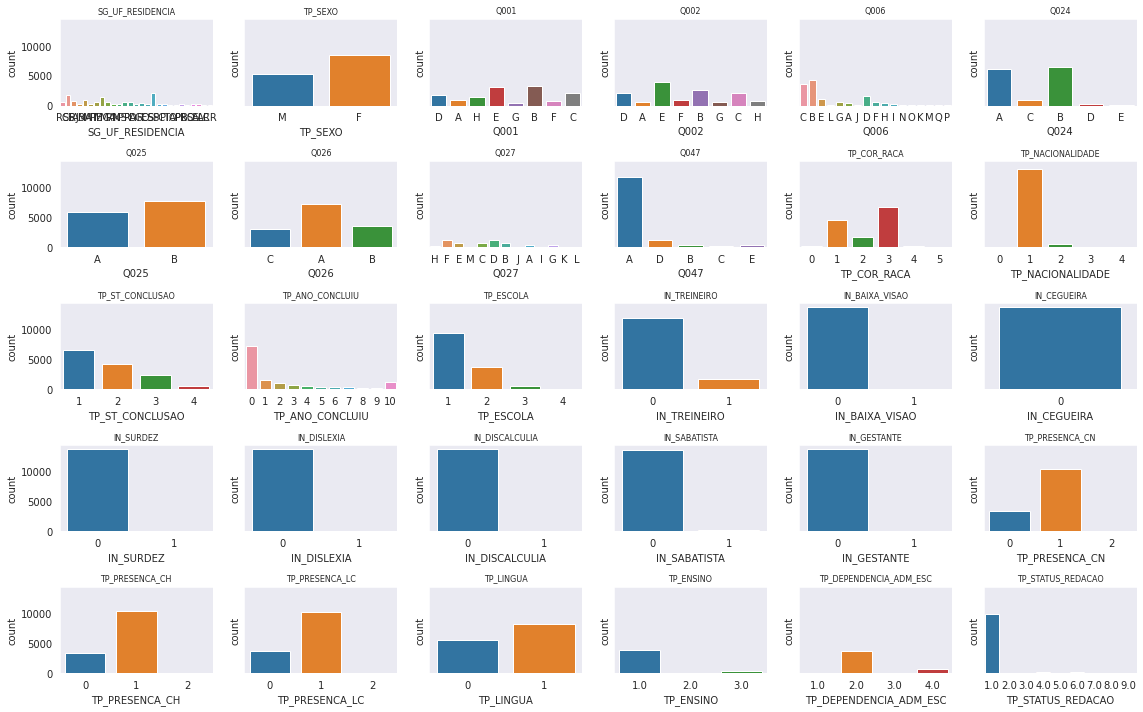

In [13]:
# Barplot for value_counts to categorical variables 
fig, axes = plt.subplots(figsize=(16,10), nrows=5, ncols=6, sharey=True)
axes = axes.flatten()

for feature, ax in zip(categorical, axes):
    ax.set_title(feature, fontsize=8)
    sns.countplot(
        x=feature, 
        data=df_train,
        ax=ax)
        # Change xlabels in Exams
    if feature in ['CO_PROVA_CN','CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT']:
        labels = [item.get_text() for item in ax.get_xticklabels()]
        ax.set_xticklabels(np.arange(len(labels)))
fig.tight_layout()

### Manually drop features
Some features doesn't add too much information (variance), they are extremelly unbalanced, or can generate some bias. So, I will drop them.

In [14]:
# Function to drop columns
def drop_columns(dataframe, columns_list):
    dataframe = dataframe.drop(columns_list, axis='columns')
    return dataframe

In [15]:
cat_irrelevant = [    
    'IN_BAIXA_VISAO','IN_CEGUEIRA', 'IN_SURDEZ', 
    'IN_DISLEXIA','IN_DISCALCULIA', 'IN_SABATISTA', 
    'IN_GESTANTE', 'TP_NACIONALIDADE', 'TP_COR_RACA',
    'TP_SEXO', 'TP_STATUS_REDACAO'
    ]
# Removing it fom categorical list
categorical = [item for item in categorical if item not in cat_irrelevant]

# Dropping it from dataframe
df_train = drop_columns(df_train, cat_irrelevant)
df_test = drop_columns(df_test, cat_irrelevant)

# Handling Missing data
Let's find out how messy is the dataset

In [16]:
# Function to check missing data
def missing_data(dataframe):
    missing = pd.DataFrame({'dtype': dataframe.dtypes,
                            'unique vals': dataframe.nunique(),
                            'missing%': (dataframe.isna().sum() / dataframe.shape[0]) * 100})
    # Get columns with missing% greater than 0
    missing = missing[missing['missing%'] > 0]
    missing = missing.sort_values('missing%', ascending=False)
    
    # Columns name with missing% greater than 60%
    cols_missing_50 = list(missing[missing['missing%'] > 50].index)
    
    return missing, cols_missing_50

In [17]:
# Check missing data
dftest_missing, missing_test_cols50 = missing_data(df_test)
dftrain_missing, missing_train_cols50 = missing_data(df_train)

# Checking
display_side_by_side(dftest_missing, dftrain_missing)

,dtype,unique vals,missing%
TP_ENSINO,float64,3,68.796499
TP_DEPENDENCIA_ADM_ESC,float64,4,68.796499
Q027,object,13,53.326039
NU_NOTA_LC,float64,1881,25.601751
NU_NOTA_COMP1,float64,12,25.601751
NU_NOTA_COMP2,float64,12,25.601751
NU_NOTA_COMP3,float64,12,25.601751
NU_NOTA_COMP4,float64,12,25.601751
NU_NOTA_COMP5,float64,11,25.601751
NU_NOTA_REDACAO,float64,46,25.601751


In [18]:
# Drop columns with missing% > 50
df_test = drop_columns(df_test, missing_test_cols50)
df_train = drop_columns(df_train, missing_train_cols50)

# Also, lets drop this in categorical list
for item in missing_train_cols50:
    categorical.remove(item)

In [19]:
# Check categorical features and dtypes
df_train[categorical].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13730 entries, 0 to 13729
Data columns (total 16 columns):
SG_UF_RESIDENCIA    13730 non-null object
Q001                13730 non-null object
Q002                13730 non-null object
Q006                13730 non-null object
Q024                13730 non-null object
Q025                13730 non-null object
Q026                13730 non-null object
Q047                13730 non-null object
TP_ST_CONCLUSAO     13730 non-null int64
TP_ANO_CONCLUIU     13730 non-null int64
TP_ESCOLA           13730 non-null int64
IN_TREINEIRO        13730 non-null int64
TP_PRESENCA_CN      13730 non-null int64
TP_PRESENCA_CH      13730 non-null int64
TP_PRESENCA_LC      13730 non-null int64
TP_LINGUA           13730 non-null int64
dtypes: int64(8), object(8)
memory usage: 1.7+ MB


In [20]:
# Check numerical features and dtypes
df_train[numeric].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13730 entries, 0 to 13729
Data columns (total 12 columns):
NU_IDADE           13730 non-null int64
TP_PRESENCA_MT     13730 non-null int64
NU_NOTA_CN         10341 non-null float64
NU_NOTA_CH         10341 non-null float64
NU_NOTA_LC         10133 non-null float64
NU_NOTA_COMP1      10133 non-null float64
NU_NOTA_COMP2      10133 non-null float64
NU_NOTA_COMP3      10133 non-null float64
NU_NOTA_COMP4      10133 non-null float64
NU_NOTA_COMP5      10133 non-null float64
NU_NOTA_REDACAO    10133 non-null float64
NU_NOTA_MT         10133 non-null float64
dtypes: float64(10), int64(2)
memory usage: 1.3 MB


### Manually filling missing data
If the student was absent on exam, their grades should be 0. So, I will check if student was absent in all tests, if this is true I will fill missing data as 0.

In [21]:
# Check if student was absent on exam when grades are missing 
def fill_grades(dataframe, subject):
    condition = dataframe[
        (dataframe['TP_PRESENCA_CN'] == 0) & 
        (dataframe['TP_PRESENCA_CH'] == 0) &
        (dataframe['TP_PRESENCA_LC'] == 0)
        ].index
    # If student wasn't take the exam I fill math grades with 0
    dataframe.loc[condition, subject] = dataframe.loc[condition,subject].fillna(0)
    
    return dataframe

In [22]:
# Filling in df_train
for col in ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT']:
    df_train = fill_grades(df_train, col)

# Filling in df_test
for col in ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC']:
    df_test = fill_grades(df_test, col)

# Displaying
display_side_by_side(
    df_train[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT']].head(7),
    df_test[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC']].head(7))

NU_NOTA_CN 
 NU_NOTA_CH 
 NU_NOTA_LC 
 NU_NOTA_MT 
 
 
 
 
 0 
 436.3 
 495.4 
 581.2 
 399.4 
 
 
 1 
 474.5 
 544.1 
 599.0 
 459.8 
 
 
 2 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 3 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 4 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 5 
 439.7 
 583.2 
 410.9 
 364.5 
 
 
 6 
 420.1 
 604.2 
 484.5 
 529.2 
 
 
 
 
 
 
 NU_NOTA_CN 
 NU_NOTA_CH 
 NU_NOTA_LC 
 
 
 
 
 0 
 495.3 
 593.3 
 NaN 
 
 
 1 
 0.0 
 0.0 
 0.0 
 
 
 2 
 559.1 
 529.3 
 NaN 
 
 
 3 
 475.0 
 557.8 
 542.0 
 
 
 4 
 440.5 
 596.1 
 594.2 
 
 
 5 
 401.1 
 452.3 
 458.6 
 
 
 6 
 0.0 
 0.0 
 0.0

# Classification
What we gonna do?

**1. Preprocessing**
*   Create Pipeline to fill missing data 
    *   categorical
    *   numerical
    
**2. Feature Selection**
*   Use GridSearch to tune RF
    *   Choose and fit best RF model
    
*   Select best parameters

**3. Rebalanced dataset**
*   Downsampling
*   SMOT 

**4. Classification**
*   Random Forest Classifier
*   Gradient Boost

**5. Model evaluation**
*   Accuracy
*   F1 score
*   Confusion Matrix

    ____________________________
**Additional Info**:
*   [Random Forest for feature selection](https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e)
*   [Unbalanced Dataset](https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18)
*   [Kaggle Notebook for imbalanced dataset](https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets)

**PS**:
Here I opted to use LabelEncoder instead of OneHotEncode (OHE). Because of this I only use ensemble classifiers (i.e. Random Forest and Gradient Boosting) because they not "require" OHE. In future, I plan to construct classes to create a better workflow for data processing and classification.

## Preprocessing

In [23]:
# Create Pipelines for numerical and categorical features
# Numerical Pipeline
num_pip = Pipeline(
    steps=[
        ('input', SimpleImputer(missing_values=np.nan, strategy='mean'))
        ])

# Categorical Pipeline for Ensembler
cat_pip = Pipeline(
    steps=[
        ('input', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing'))
        ])

# Join both Pipelines with ColumnTransformer
preprocess_pipe = ColumnTransformer(
    transformers=[
                ('numerical', num_pip, numeric),
                ('categorical', cat_pip, categorical)
                ])

In [24]:
# Train data
# 1st: Preprocessing (fill missing data)
preprocess_ = preprocess_pipe.fit_transform(df_train)
train_processed = pd.DataFrame(preprocess_, columns=(numeric + categorical))

# # 2nd: Label Encoder for categorical
le = LabelEncoder()
for col in categorical:
    train_processed[col] = le.fit_transform(train_processed[col].values)

# Remove target variable from features
categorical.remove('IN_TREINEIRO')

# Setting X and Y variables
X = train_processed[numeric + categorical]
Y = train_processed.loc[:, 'IN_TREINEIRO']

# Split train
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.30, random_state=13)

print('Training Features Shape:', train_x.shape)
print('Training target Shape:', train_y.shape)
print('Testing Features Shape:', test_x.shape)
print('Testing target Shape:', test_y.shape)

Training Features Shape: (9611, 27)
Training target Shape: (9611,)
Testing Features Shape: (4119, 27)
Testing target Shape: (4119,)


## Feature Selection

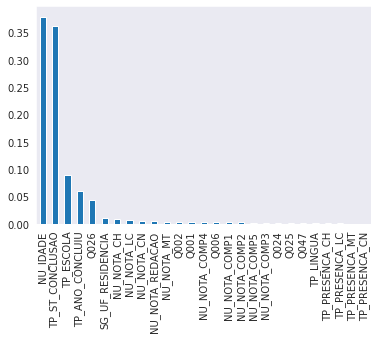

In [25]:
# Running RandomForest Regressor
%timeit

# RandomForest 
rf = RandomForestClassifier(random_state=13)

parameters = {
    'n_estimators': [50, 100, 150],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [50, 100, 150],
    'min_samples_split': [5, 20, 50],
    'min_samples_leaf': [5, 20],
    'bootstrap': [True], 
    'oob_score': [True]
}

# Grid search
model_rf = GridSearchCV(
    estimator=rf,
    param_grid=parameters, 
    cv=KFold(n_splits=5, shuffle=True),
    n_jobs=-1
)

# Fitting
model_rf.fit(train_x, train_y)

# Best model: model_rf.best_estimator_
# Plotting feature importance
feature_scores = model_rf.best_estimator_.feature_importances_
feature_scores = pd.Series(feature_scores, index=train_x.columns).sort_values(ascending=False)
feature_scores.plot(kind='bar')

In [26]:
# Selecting best features
features_select = feature_scores[feature_scores > 0.05].index.tolist()

## Rebalance dataset

In [27]:
# Check proportion
def value_count(dataframe):
    count_treineiro = dataframe.value_counts()
    count_treineiro = [round(val * 100 / np.sum(count_treineiro), 2) for val in count_treineiro]
    return count_treineiro
    

In [28]:
value_count(train_y), value_count(test_y)

([87.34, 12.66], [86.26, 13.74])

### Undersample technique 
We have an imbalanced dataset, so I will test some approaches to deal with this problem.

In [29]:
# Joining train data (already splitted)
train_xy = pd.concat([train_x[features_select], train_y], axis=1)
non_treineiro = train_xy[train_xy['IN_TREINEIRO'] == 0]
treineiro = train_xy[train_xy['IN_TREINEIRO'] == 1]

# Undersampling students non "treineiro"
non_treineiro_downsampled = resample(non_treineiro,
                                replace = False,
                                n_samples = len(treineiro),
                                random_state = 13) 

# combine minority and downsampled majority
downsampled = pd.concat([
    non_treineiro_downsampled, 
    treineiro],
    axis='rows')

# Shuffle dataset
downsampled = downsampled.sample(frac=1)
downsampled.tail(5)

,NU_IDADE,TP_ST_CONCLUSAO,TP_ESCOLA,TP_ANO_CONCLUIU,IN_TREINEIRO
9643,17,2,0,0,1
13427,18,2,0,0,1
13369,17,1,2,0,0
132,34,0,0,10,0
13315,17,2,0,0,1


In [30]:
# Re-split unsample training dataset 
train_x_unsample = downsampled[features_select]
train_y_unsample = downsampled.loc[:, 'IN_TREINEIRO']

### Synthetic technique

In [31]:
from imblearn.over_sampling import SMOTE
# Using SMOTE to balance IN_TREINEIRO
smote = SMOTE(
    sampling_strategy='minority',
    random_state=13, 
     n_jobs=-1)

# Fit SMOTE to train 
train_x_syn, train_y_syn = smote.fit_sample(train_x[features_select], train_y)

# Check synthetic train proportion
train_y_syn.value_counts()

1    8394
0    8394
Name: IN_TREINEIRO, dtype: int64

## Classification

### Random Forest

In [32]:
%%time
# Fitting RF with undersampled data
model_rf.fit(train_x_unsample, train_y_unsample)

# Classify
rf_predict = model_rf.best_estimator_.predict(test_x[features_select])

# Checking accuracy
accuracy_rf = metrics.accuracy_score(test_y, rf_predict)
f1_rf = metrics.f1_score(test_y, rf_predict)
recall_rf = metrics.recall_score(test_y, rf_predict)

print(f"Accuracy {accuracy_rf}, F1 score {f1_rf}, recall {recall_rf}")

Accuracy 0.9825200291332847, F1 score 0.9401993355481728, recall 1.0
CPU times: user 1.49 s, sys: 31.8 ms, total: 1.52 s
Wall time: 24.5 s


In [33]:
%%time
# Fitting RF with sythetic data
model_rf.fit(train_x_syn, train_y_syn)

# Classify
rf_predict_syn = model_rf.best_estimator_.predict(test_x[features_select])

# Checking accuracy
accuracy_rf = metrics.accuracy_score(test_y, rf_predict_syn)
f1_rf = metrics.f1_score(test_y, rf_predict_syn)
recall_rf = metrics.recall_score(test_y, rf_predict_syn)

print(f"Accuracy {accuracy_rf}, F1 score {f1_rf}, recall {recall_rf}")

Accuracy 0.9847050254916242, F1 score 0.9472803347280335, recall 1.0
CPU times: user 3.57 s, sys: 285 ms, total: 3.85 s
Wall time: 1min 8s


[Text(0, 0.5, 'Non treineiro'), Text(0, 1.5, 'Treineiro')]

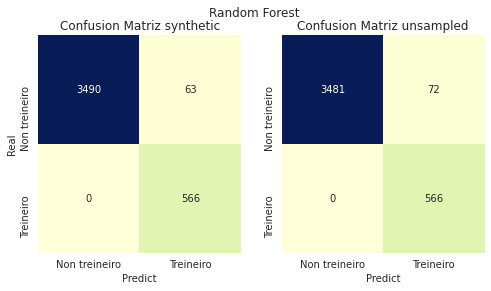

In [34]:
# Confusion Matrix
rf_syn = metrics.confusion_matrix(test_y, rf_predict_syn)
rf_uns = metrics.confusion_matrix(test_y, rf_predict)

fig, ax = plt.subplots(figsize=(8,4), nrows=1, ncols=2)
sns.heatmap(rf_syn, cmap="YlGnBu", annot=True, fmt="d", cbar=False, ax=ax[0])
sns.heatmap(rf_uns, cmap="YlGnBu", annot=True, fmt="d", cbar=False, ax=ax[1])

fig.suptitle('Random Forest')
ax[0].set_title("Confusion Matriz synthetic")
ax[1].set_title("Confusion Matriz unsampled")
ax[0].set_ylabel("Real")

ax[0].set_xlabel("Predict")
ax[1].set_xlabel("Predict")

ax[0].set_xticklabels(["Non treineiro", "Treineiro"])
ax[1].set_xticklabels(["Non treineiro", "Treineiro"])

ax[0].set_yticklabels(["Non treineiro", "Treineiro"])
ax[1].set_yticklabels(["Non treineiro", "Treineiro"])

### Gradient Boosting 

In [35]:
%%time
gb = GradientBoostingClassifier(random_state=13)

parameters_gb = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 150],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [50, 100, 150],
    'min_samples_split': [5, 20, 50],
    'min_samples_leaf': [5, 20]
}

# Grid search
model_gb = GridSearchCV(
    estimator=gb,
    param_grid=parameters_gb, 
    cv=KFold(n_splits=5, shuffle=True),
    n_jobs=-1
)

# Fitting RF with undersampled data
model_gb.fit(train_x_unsample, train_y_unsample)

# Classify
model_gb_predict = model_gb.best_estimator_.predict(test_x[features_select])

# Checking accuracy
accuracy_gb = metrics.accuracy_score(test_y, model_gb_predict)
f1_gb = metrics.f1_score(test_y, model_gb_predict)
recall_gb = metrics.recall_score(test_y, model_gb_predict)

print(f"Accuracy {accuracy_gb}, F1 score {f1_gb}, recall {recall_gb}")

Accuracy 0.9825200291332847, F1 score 0.9401993355481728, recall 1.0
CPU times: user 3.88 s, sys: 156 ms, total: 4.04 s
Wall time: 1min 3s


In [36]:
%%time
# Fitting RF with sythetic data
model_gb.fit(train_x_syn, train_y_syn)

# Classify
model_gb_predict_syn = model_gb.best_estimator_.predict(test_x[features_select])

# Checking accuracy
accuracy_gb_syn = metrics.accuracy_score(test_y, model_gb_predict_syn)
f1_gb_syn = metrics.f1_score(test_y, model_gb_predict_syn)
recall_g_syn = metrics.recall_score(test_y, model_gb_predict_syn)

print(f"Accuracy {accuracy_gb_syn}, F1 score {f1_gb_syn}, recall {recall_g_syn}")

Accuracy 0.9847050254916242, F1 score 0.9472803347280335, recall 1.0
CPU times: user 10.6 s, sys: 763 ms, total: 11.4 s
Wall time: 4min 18s


[Text(0, 0.5, 'Non treineiro'), Text(0, 1.5, 'Treineiro')]

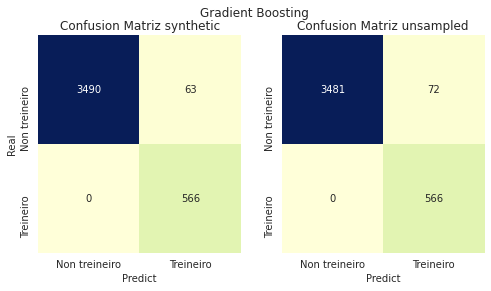

In [37]:
# Confusion Matrix
gb_syn = metrics.confusion_matrix(test_y, model_gb_predict_syn)
gb_uns = metrics.confusion_matrix(test_y, model_gb_predict)

fig, ax = plt.subplots(figsize=(8,4), nrows=1, ncols=2)
sns.heatmap(gb_syn, cmap="YlGnBu", annot=True, fmt="d", cbar=False, ax=ax[0])
sns.heatmap(gb_uns, cmap="YlGnBu", annot=True, fmt="d", cbar=False, ax=ax[1])

fig.suptitle('Gradient Boosting')
ax[0].set_title("Confusion Matriz synthetic")
ax[1].set_title("Confusion Matriz unsampled")
ax[0].set_ylabel("Real")

ax[0].set_xlabel("Predict")
ax[1].set_xlabel("Predict")

ax[0].set_xticklabels(["Non treineiro", "Treineiro"])
ax[1].set_xticklabels(["Non treineiro", "Treineiro"])

ax[0].set_yticklabels(["Non treineiro", "Treineiro"])
ax[1].set_yticklabels(["Non treineiro", "Treineiro"])

# Classifying test data
Random Forest Classifier and Gradient Boosting using synthetic data achieved similar results I will chose Random Forest classifier.

In [38]:
# Pipeline for processing df_test
# Test data
# 1st: Preprocessing (fill missing data)
numeric.remove('NU_NOTA_MT')
preprocess_ = preprocess_pipe.fit_transform(df_test)
test_processed = pd.DataFrame(preprocess_, columns=(numeric + categorical))

# 2nd: Label Encoder for categorical
le = LabelEncoder()
for col in features_select:
    test_processed[col] = le.fit_transform(test_processed[col].values)

# Predicting
predict = model_rf.best_estimator_.predict(test_processed[features_select])

# Export to a csv
predict_results = pd.DataFrame(
    {'NU_INSCRICAO': test_raw['NU_INSCRICAO'],
    'IN_TREINEIRO': predict
    })
predict_results.to_csv('./answers.csv', index=False)
predict_results.head(4)

,NU_INSCRICAO,IN_TREINEIRO
0,ba0cc30ba34e7a46764c09dfc38ed83d15828897,0
1,177f281c68fa032aedbd842a745da68490926cd2,0
2,6cf0d8b97597d7625cdedc7bdb6c0f052286c334,1
3,5c356d810fa57671402502cd0933e5601a2ebf1e,0
